In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
#load CIFAR-10 data
from torchvision import datasets
from torchvision import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data_cifar = datasets.CIFAR10('data_cifar', train=True, download=True, transform=transform)
test_data_cifar = datasets.CIFAR10('data_cifar', train=False, download=True, transform=transform)

train_loader_cifar = DataLoader(train_data_cifar, batch_size=64, shuffle=True)
test_loader_cifar = DataLoader(test_data_cifar, batch_size=64, shuffle=True)



Files already downloaded and verified
Files already downloaded and verified


In [5]:
#load mnist dataset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32, 32))
])

train_data_mnist = datasets.MNIST('data_mnist', train=True, download=True, transform=transform)
test_data_mnist = datasets.MNIST('data_mnist', train=False, download=True, transform=transform)

train_loader_mnist = DataLoader(train_data_mnist, batch_size=64, shuffle=True)
test_loader_mnist = DataLoader(test_data_mnist, batch_size=64, shuffle=True)


### RPE Methodologies
- General Learnable Function: $f_\Theta : \mathbb{R} \rightarrow \mathbb{R}$
- Monotonically Decreasing Function: $f = e^{-\alpha x}$
- Ratio of two polynomial functions: $f = \frac{h}{g}$

In [6]:
class GeneralFunction(nn.Module):
    def __init__(self, embedding_dim):
        super(GeneralFunction, self).__init__()
        self.fc = nn.Linear(1, embedding_dim)

    def forward(self, distances):
        batch_size, num_patches, _ = distances.size()
        distances = distances.unsqueeze(-1) 
        positional_encodings = self.fc(distances)
        return positional_encodings


In [7]:
#testing the general RPE function
gf = GeneralFunction(64)
distances = torch.randn(32, 49, 47)
positional_encodings = gf(distances)
print(positional_encodings.shape)  # Expected output: torch.Size([32, 49, 47, 64])

torch.Size([32, 49, 47, 64])


### Patch the Images

torch.Size([32, 32])


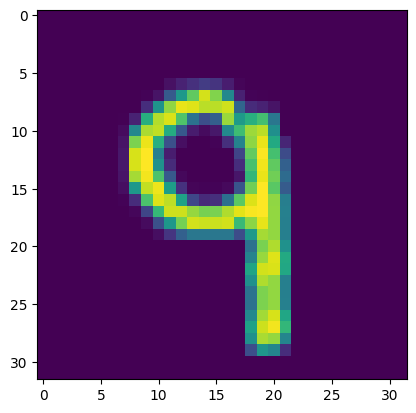

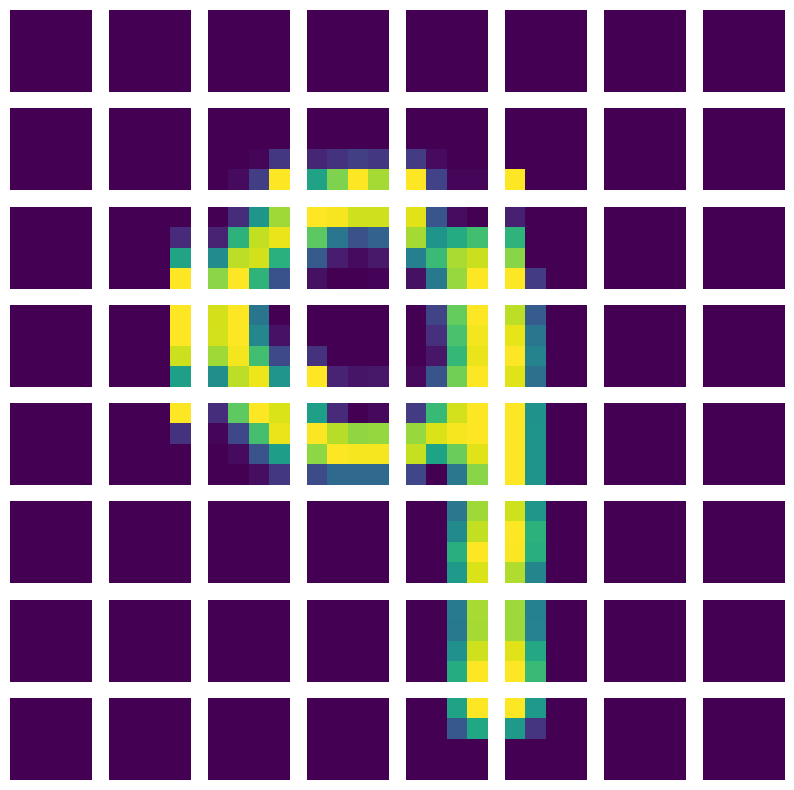

In [24]:
#patch a single image from the MNIST dataset
patch_size = 4
image_size = 32

image, label = next(iter(train_loader_mnist))
image = image[0].squeeze()
print(image.shape)
patches = image.reshape(image_size//patch_size, patch_size, -1, patch_size).swapaxes(1,2).reshape(-1, patch_size, patch_size)

#imshow the original image and then the patched image
plt.imshow(image)
plt.show()

plt.figure(figsize=(10, 10))
for i in range(patches.shape[0]):
    plt.subplot(8, 8, i+1)
    plt.imshow(patches[i])
    plt.axis('off')
